In [20]:
from reader import read_file
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
from nd2reader import ND2Reader
import math, pims, yaml, gc, csv, os, glob, pickle

import numpy as np
from numpy.polynomial import Polynomial

from skimage import measure, io
from skimage.measure import label, regionprops

from scipy import ndimage

def check_span(image, R_thresh):
    
    def binarize(frame, offset_threshold):
        avg_intensity = np.mean(frame)
        threshold = avg_intensity * (1 + offset_threshold)
        new_frame = np.where(frame < threshold, 0, 1)
        return new_frame
    
    def check_connected(frame, axis=0):
        # Ensures that either 
        if axis == 0:
            first = (frame[0] == 1).any()
            last = (frame[len(frame) - 1] == 1).any()
        elif axis == 1:
            first = (frame[:,0] == 1).any()
            last = (frame[:,len(frame[:]) - 1] == 1).any()
        else:
            raise Exception("Axis must be 0 or 1.")
    
        struct = ndimage.generate_binary_structure(2, 2)
    
        frame_connections, num_features = ndimage.label(input=frame, structure=struct)
    
        if axis == 0:
            labeled_first = np.unique(frame_connections[0,:])
            labeled_last = np.unique(frame_connections[-1,:])
    
        if axis == 1:
            labeled_first = np.unique(frame_connections[:,0])
            labeled_last = np.unique(frame_connections[:,-1])
    
        labeled_first = set(labeled_first[labeled_first != 0])
        labeled_last = set(labeled_last[labeled_last != 0])
    
        if labeled_first.intersection(labeled_last):
            return 1
        else:
            return 0
        
        
    first_frame = binarize(image[0], R_thresh)
    last_frame = binarize(image[-1], R_thresh)
    return (check_connected(first_frame) and check_connected(last_frame)) or (check_connected(first_frame, axis = 1) and check_connected(last_frame, axis = 1))

def track_void(image, threshold, step):
    def binarize(frame, offset_threshold):
        avg_intensity = np.mean(frame)
        threshold = avg_intensity * (1 + offset_threshold)
        new_frame = np.where(frame < threshold, 0, 1)
        return new_frame
        
    def find_largest_void(frame, find_void = True):      
        if find_void:
            frame = np.invert(frame)
        labeled, a = label(frame, connectivity= 2, return_num =True) # identify the regions of connectivity 2
        regions = regionprops(labeled) # determines the region properties of the labeled
        largest_region = max(regions, key = lambda r: r.area) # determines the region with the maximum area
        return largest_region.area # returns largest region area

    def largest_island_position(frame):      
        labeled, a = label(frame, connectivity = 2, return_num =True) # identify the regions of connectivity 2
        regions = regionprops(labeled) # determines the region properties of the labeled
        largest_region = max(regions, key = lambda r: r.area) # determines the region with the maximum area
        return largest_region.centroid # returns largest region area
    
    def find_largest_void_regions(frame):
        return max(find_largest_void_mid(frame, find_void = True), find_largest_void_mid(frame, find_void = False))
    
    void_lst = []
    island_area_lst = []
    island_position_lst = []
    
    for i in range(0, len(image), step):
        new_frame = binarize(image[i], threshold)
        void_area = find_largest_void(new_frame)
        island_area = find_largest_void(new_frame, find_void = False)
        island_position = largest_island_position(new_frame)
        void_lst.append(void_area)
        island_area_lst.append(island_area)
        island_position_lst.append(island_position)
    return void_lst, island_area_lst, island_position_lst

def check_resilience(file, channel, R_offset, percent_threshold_loss, percent_threshold_gain, frame_step, frame_start_percent, frame_stop_percent):
    #Note for parameters: frame_step (stepsize) used to reduce the runtime. 
    image = file[:,:,:,channel]
    frame_initial_percent = 0.05

    fig, ax = plt.subplots(figsize = (5,5))

    # Error Checking: Empty Image
    if (image == 0).all():
        verdict = "Data not available for this channel."
        return verdict, fig
    
    largest_void_lst, island_area_lst, island_position_lst = track_void(image, R_offset, frame_step)
    start_index = int(len(largest_void_lst) * frame_start_percent)
    stop_index = int(len(largest_void_lst) * frame_stop_percent)
    start_initial_index = int(len(largest_void_lst)*frame_initial_percent)

    percent_gain_initial_list = np.mean(largest_void_lst[0:start_initial_index])
    percent_gain_list = np.array(largest_void_lst)/percent_gain_initial_list
    
    ax.plot(np.arange(start_index, stop_index), percent_gain_list[start_index:stop_index])
    ax.set_xlabel("Frames")
    ax.set_ylabel("Proportion of orginal void size")
    #Calculate
    
    avg_percent_change = np.mean(largest_void_lst[start_index:stop_index])/percent_gain_initial_list
    max_void_size = max(largest_void_lst)/(len(image[0,0,:])*len(image[0,:,0]))
    island_size = max(island_area_lst)/(len(image[0,0,:])*len(image[0,:,0]))
    island_movement = np.array(island_position_lst[0]) - np.array(island_position_lst[-1])
    print(len(island_position_lst))
    print(island_movement.shape)
    print(island_movement)
    island_speed = np.linalg.norm(island_movement)
    island_direction = np.arctan2(island_movement[1],island_movement[0])
    island_direction = island_direction[np.where(island_speed < 15)]
    average_direction = np.average(island_direction)
    #Give judgement
    if avg_percent_change >= percent_threshold_loss and avg_percent_change <= percent_threshold_gain or max_void_size < 0.10:
        verdict = 1
    else:
        verdict = 0
    
    spanning = check_span(image, R_offset)
    
    return verdict, fig, max_void_size, spanning, island_size, average_direction, avg_percent_change

In [11]:
filepath = '../../../../../Volumes/Hack2024D/102523/55min.nd2'
file = read_file(filepath)
file.shape

(560, 512, 512, 3)

56
(2,)
[268.67622429  44.25365174]


/var/folders/2z/sb0dct2j3vb07sbc2nsfjyfh0000gp/T/ipykernel_18391/2482303461.py:132: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  island_direction = island_direction[np.where(island_speed < 15)]


IndexError: invalid index to scalar variable.

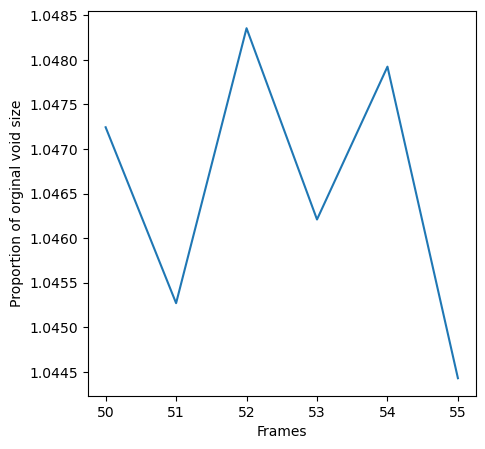

In [21]:
v, f, m, s, i, ad, apc = check_resilience(file, 0, 0, 0.9, 1.1, 10, 0.9, 1)

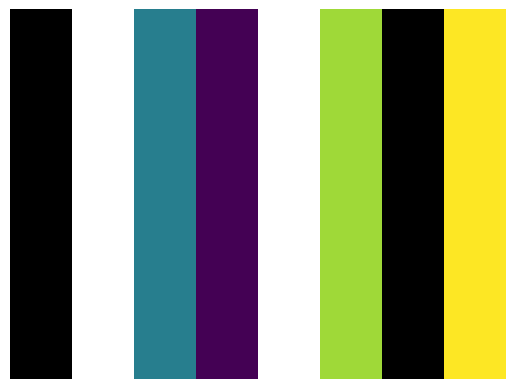

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def create_color_barcode(data):
    # Define color mappings
    binary_colors = {0: [0, 0, 0], 1: [1, 1, 1]}  # Black for 0, white for 1
    colormap = plt.get_cmap('viridis')  # Colormap for floats

    # Normalize float values to be between 0 and 1
    float_values = [x for x in data if isinstance(x, float)]
    min_float, max_float = min(float_values), max(float_values)
    
    def normalize(x):
        return (x - min_float) / (max_float - min_float)

    # Create the color barcode
    barcode = []
    for value in data:
        if isinstance(value, int):
            color = binary_colors[value]
        elif isinstance(value, float):
            color = colormap(normalize(value))[:3]  # Exclude the alpha channel
        barcode.append(color)
    
    # Convert to numpy array and reshape for plotting
    barcode = np.array(barcode)
    barcode_image = np.tile(barcode, (1, 1, 1))  # Repeat the barcode to make it visible

    # Plot and save the barcode
    plt.imshow(barcode_image, aspect='auto')
    plt.axis('off')
    # plt.savefig('color_barcode.png', bbox_inches='tight', pad_inches=0)

# Example usage
data = [0, 1, 0.5, 0.2, 1, 0.8, 0, 0.9]
create_color_barcode(data)
